In [38]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import yaml
from glob import glob
import pathlib

FONT_SIZE = 15
plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FONT_SIZE)  # fontsize of the figure title
matplotlib.rc('lines', linewidth=3)

In [39]:
log_dir = '/home/zhenyus/webcachesim/log'

In [57]:
def to_label(x):
    """
    what to put on legend
    """
    return yaml.dump(
        {k: x[k] for k in x.to_dict() if k not in {
            'cache_size', 
            'byte_hit_rate', 
            'object_hit_rate',
            'trace_file', 
            'n_warmup', 
            'n_early_stop',
            'task_id'
        } and not pd.isnull(x[k])
        })

def to_id(x):
    """
    unique identifier
    """
    return yaml.dump(
        {k: x[k] for k in x.to_dict() if k not in {
            'byte_hit_rate', 
            'object_hit_rate',
        } and not pd.isnull(x[k])
        })

    
def load_reports(log_dir):
    timestamps = glob(f'{log_dir}/*.res')
    timestamps = [pathlib.PurePosixPath(t).stem for t in timestamps]
    timestamps.sort()
    tasks = []
    for t in timestamps:
        with open(f'{log_dir}/{t}.res') as f:
            res = yaml.load(f)
        tasks.append({**res['res'], **res['task']})
    df = pd.DataFrame(tasks)
    df['task_id'] = df.apply(lambda x: to_id(x), axis='columns')
    df = df.drop_duplicates(keep='last', subset=[
        'task_id',
    ])
    return df

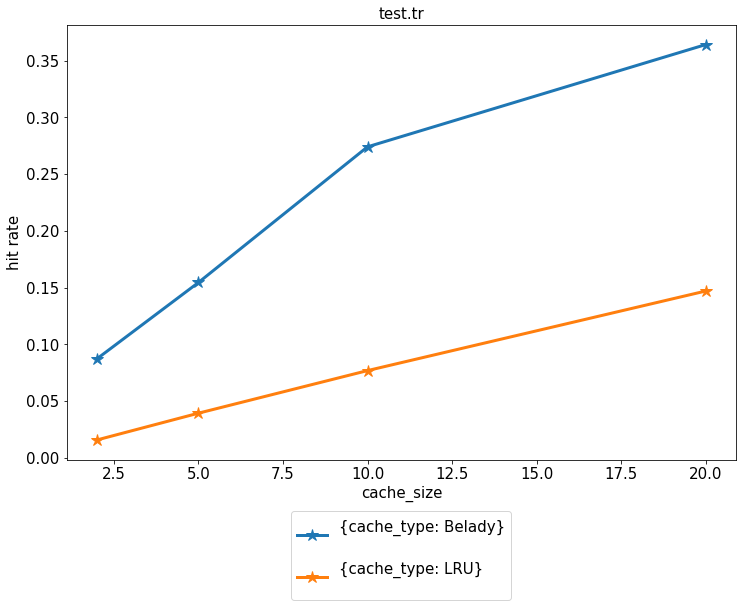

In [61]:
trace = 'test.tr'

df = load_reports(log_dir)
filter_idx = (
    (df.trace_file == trace) 
#     & (df.n_warmup == 100000)
#     & (df.if_uni_size == False)
#     & (df.cache_capacity <= 30000)
#     & (
#         (df.algorithm.isin(['SLRU', 'Belady', 'Random', 'LRU', 'BeladyLR'])) 
#         | (df.algorithm.isin(['FIFOLR', 'LRULR', 'GDSFLR', 'LFULR']))
#         | ((df.algorithm == 'LR') & (df.sample_rate == 32))
#         | ((df.algorithm == 'SLRULR') & (df.sample_rate == 32))
#     )
)

# df1 = df[filter_idx].copy()
df1 = df
df1['label'] = df1.apply(lambda x: to_label(x), axis='columns')
fig, ax = plt.subplots(figsize=(12, 8))
for k, grp in df1.groupby(['label']):
    grp = grp.sort_values(by=['cache_size'])
    ax = grp.plot(ax=ax, kind='line', x='cache_size', y='byte_hit_rate', label=k, marker='*', markersize=12)
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1))
plt.ylabel('hit rate')
plt.title(trace)
plt.show()

In [62]:
df1

,byte_hit_rate,cache_size,cache_type,object_hit_rate,task_id,trace_file,label
0,0.039310,5,LRU,0.052135,"{cache_size: 5, cache_type: LRU, task_id: 1, t...",test.tr,{cache_type: LRU}\n
1,0.076843,10,LRU,0.088830,"{cache_size: 10, cache_type: LRU, task_id: 2, ...",test.tr,{cache_type: LRU}\n
2,0.015734,2,LRU,0.027259,"{cache_size: 2, cache_type: LRU, task_id: 0, t...",test.tr,{cache_type: LRU}\n
3,0.146942,20,LRU,0.154499,"{cache_size: 20, cache_type: LRU, task_id: 3, ...",test.tr,{cache_type: LRU}\n
4,0.087245,2,Belady,0.152688,"{cache_size: 2, cache_type: Belady, task_id: 4...",test.tr,{cache_type: Belady}\n
5,0.154469,5,Belady,0.203012,"{cache_size: 5, cache_type: Belady, task_id: 5...",test.tr,{cache_type: Belady}\n
6,0.274020,10,Belady,0.291937,"{cache_size: 10, cache_type: Belady, task_id: ...",test.tr,{cache_type: Belady}\n
7,0.364088,20,Belady,0.384483,"{cache_size: 20, cache_type: Belady, task_id: ...",test.tr,{cache_type: Belady}\n
